# Social Network Analysis - Assortativity

## 1. Project Goal

In this project, a network dataset will be analyzed as to discover <b>gender</b>'s influence on how communications, information, and advice flow through an organization. 

In [22]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
import igraph as ig
import networkx as nx
from scipy.stats import ttest_ind
from mlxtend.evaluate import permutation_test
import seaborn as sns
from IPython.display import SVG, display, HTML
import base64
_html_template='<img width="{}" src="data:image/svg+xml;base64,{}" >'
import statsmodels.api as sm
import itertools
from heatmap import heatmap, corrplot

def svg_to_fixed_width_html_image(svg, width="100%"):
    text = _html_template.format(width, base64.b64encode(svg))
    return HTML(text)

## 1. Descriptive Gender Analysis

I will analyze the sample data to see if there's any meaningful patterns on in-degree and out-degree connectivity by'label' between men and women. The survey participants were given nine labels (reasons) of communication to choose: Energy, Trust, Career Development, Personal Support, Decision Making, Access, Innovation, Problem Solving, and Strategy. 

In [3]:
#Load data into dataframe
nodes = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
link = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Links - Intragroup.csv')
nodes_all = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes.csv')
#Select columns of interst from node data 
nodes = nodes[['ID','Gender']]

#Out-degree statistics by Gender and Label
link_source = link.rename(columns = {'Source': "ID"})
out_degree1 = pd.merge(link_source,nodes,how='left',on = 'ID')
by_label_out_degree = out_degree1.groupby(['Gender','Label']).ID.count().reset_index()



#In-degree statistics by Gender and Label
link_source2 = link.rename(columns = {"Target":"ID"})
in_degree = pd.merge(link_source2,nodes,how='left',on = 'ID')
by_label_in_degree = in_degree.groupby(['Gender','Label']).ID.count().reset_index()

#Gender to gender in and out degree statistics 
in_degree.rename(columns = {'Gender': 'Gender_in','ID': 'Target2','Source':'Source2','Label':'Label2'},inplace=True)
out_degree1.rename(columns = {'Gender': 'Gender_out','ID': 'Source'},inplace=True)
combined = pd.concat([out_degree1,in_degree],axis=1)
combined = combined[['Source','Target','Label','Gender_out','Gender_in']]
gender_to_gender = combined.groupby(['Gender_out','Gender_in']).Source.count().reset_index()

#Normalizing the number of degrees
by_label_out_degree['Gender2'] = by_label_out_degree.Gender.map({'Female':0,'Male': 1})
by_label_out_degree['NormID'] = by_label_out_degree.apply(lambda row: row['ID']/ 219 if row['Gender2'] == 0 else row['ID']/ 393,axis=1)
by_label_in_degree['NormID'] = by_label_in_degree.apply(lambda row: row['ID']/219 if row['Gender']=='Female' else row['ID']/393, axis = 1)

## a. Number of survey participants 

In [11]:
link.Label.unique()

array(['Energy', 'Trust', 'Career Development', 'Personal Support',
       'Decision Making', 'Access', 'Innovation', 'Problem Solving',
       'Strategy'], dtype=object)

,Gender,ID
0,Female,219
1,Male,393


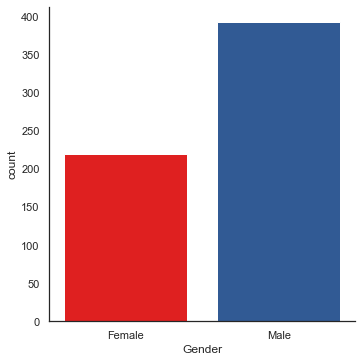

In [4]:
sns.set_theme(style='white')
g = sns.catplot(data=nodes,kind='count',x='Gender',palette = sns.color_palette(['red','#2157A4']))
nodes.groupby('Gender').ID.count().reset_index()

### <font color='darkblue'> 612 people responded to the survey. (219 - female, 393 - male)

## b. Number of out-degrees/person and in-degrees/person by gender 

Text(0.5, 1.0, 'Number of out-degrees/person (Normalized)')

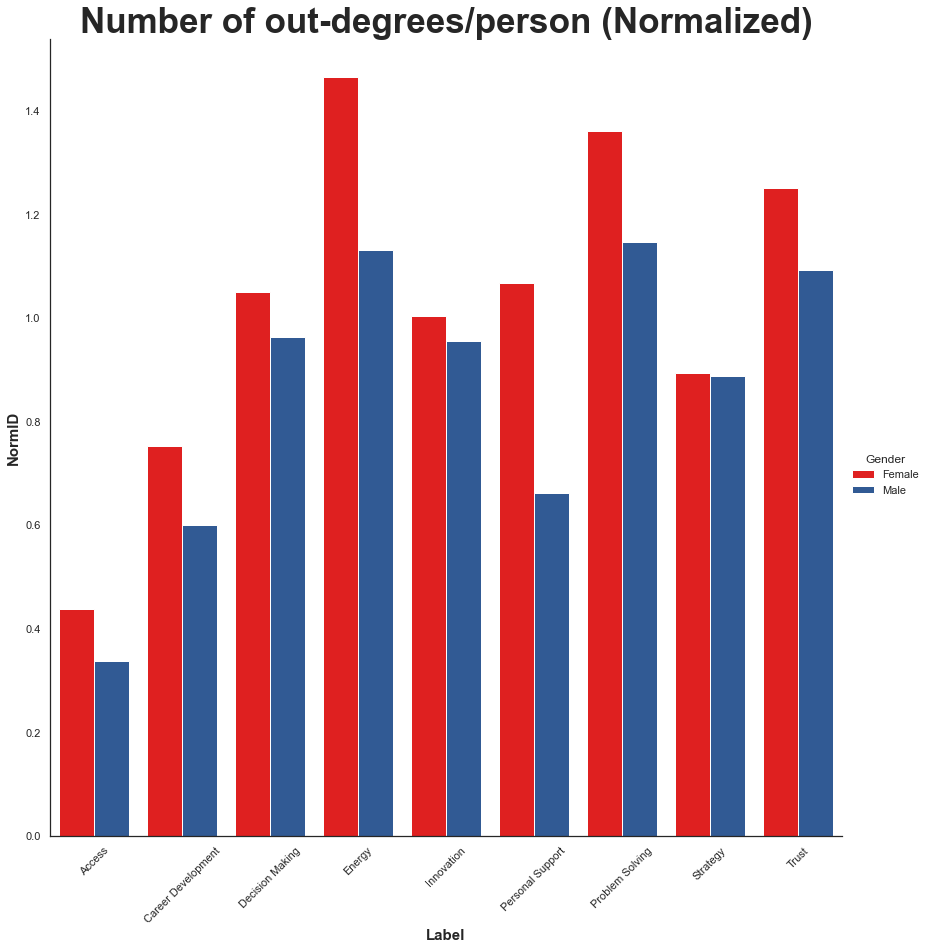

In [5]:
o = sns.catplot(data= by_label_out_degree,kind='bar',x='Label',y='NormID',hue='Gender',height = 11.7,palette = sns.color_palette(['red','#2157A4']))
o.set_xticklabels(rotation=45)
o.set_xlabels(fontsize=15,fontweight='bold')
o.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Number of out-degrees/person (Normalized)',fontsize = 35,fontweight = 'bold')

### <font color='darkblue'> Across all of the labels (communication reasons), females have more out-degrees than males. From this data, I can construct a hypothesis that females more than men. Later, I will perform a hypothesis test to see if the hypothesis is statistically significant. 

Text(0.5, 1.0, 'Number of in-degrees/person (Normalized)')

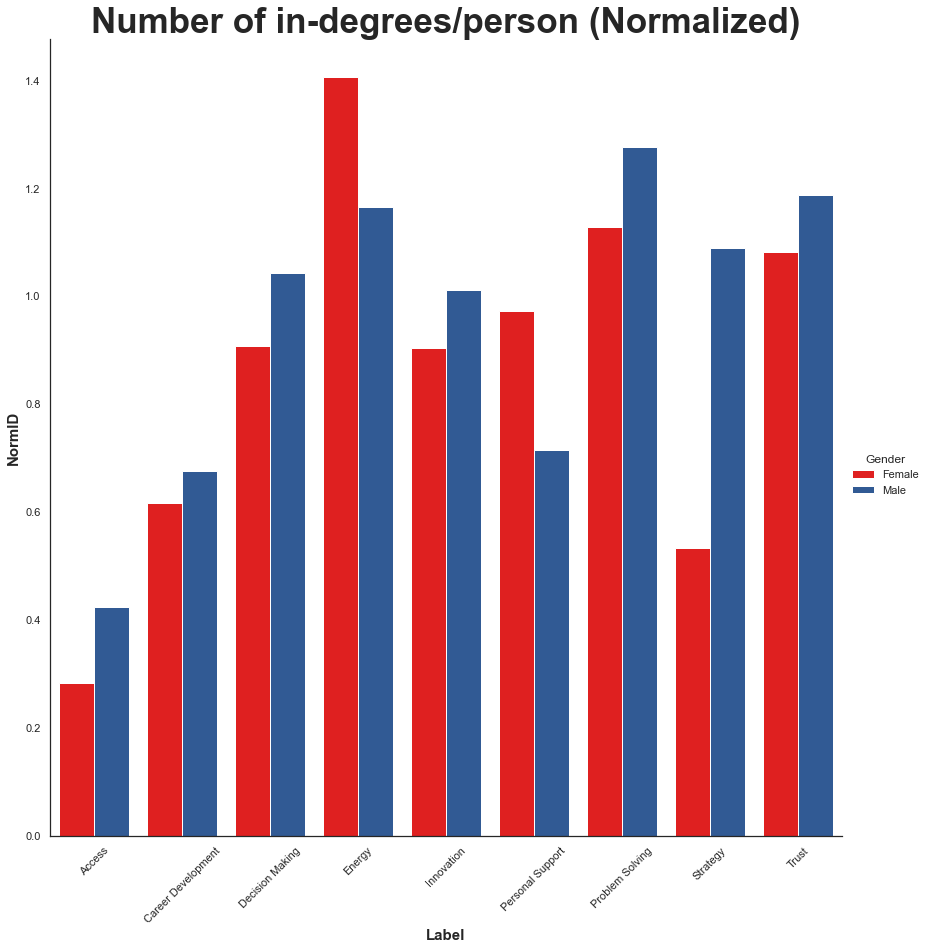

In [6]:
i = sns.catplot(data=by_label_in_degree,kind='bar',x='Label', y='NormID',hue='Gender',height = 11.7,palette = sns.color_palette(['red','#2157A4']))
i.set_xticklabels(rotation = 45)
i.set_xlabels(fontsize=15,fontweight='bold')
i.set_ylabels(fontsize=15,fontweight='bold')
plt.title('Number of in-degrees/person (Normalized)',fontsize = 35,fontweight = 'bold')

### <font color='darkblue'> Unlike the out-degree result above, males tend to have more in-degrees than women. However, for energy and personal support, females have more in-degrees. There's no dominant patterns in term of gender. 

In [17]:
#Gender to gender statistics by label
label = combined['Label'].unique()
for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    b= print('{0}'.format(label[i]),sector_group)

Energy   Gender_out Gender_in  Source
0     Female    Female     190
1     Female      Male     131
2       Male    Female     118
3       Male      Male     327
Trust   Gender_out Gender_in  Source
0     Female    Female     137
1     Female      Male     137
2       Male    Female     100
3       Male      Male     330
Career Development   Gender_out Gender_in  Source
0     Female    Female      81
1     Female      Male      84
2       Male    Female      54
3       Male      Male     182
Personal Support   Gender_out Gender_in  Source
0     Female    Female     154
1     Female      Male      80
2       Male    Female      59
3       Male      Male     201
Decision Making   Gender_out Gender_in  Source
0     Female    Female     114
1     Female      Male     116
2       Male    Female      85
3       Male      Male     294
Access   Gender_out Gender_in  Source
0     Female    Female      34
1     Female      Male      62
2       Male    Female      28
3       Male      Male     10

In [24]:
sector

,Source,Target,Label,Gender_out,Gender_in
0,427685,428855,Energy,Female,Female
5,428309,428686,Energy,Male,Male
16,428335,428660,Energy,Male,Male
31,428361,428647,Energy,Male,Male
38,428387,428322,Energy,Male,Male
...,...,...,...,...,...
5066,427490,426567,Energy,Female,Female
5068,427490,426697,Energy,Female,Female
5070,427633,427958,Energy,Male,Male
5079,427789,424916,Energy,Female,Female


In [48]:
label

array(['Energy', 'Trust', 'Career Development', 'Personal Support',
       'Decision Making', 'Access', 'Innovation', 'Problem Solving',
       'Strategy'], dtype=object)

"'for i in range(0,len(label)):\n    sector = combined[combined['Label'] == label[i]]\n    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()\n    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')\n    sns.heatmap(data=sector_group)"

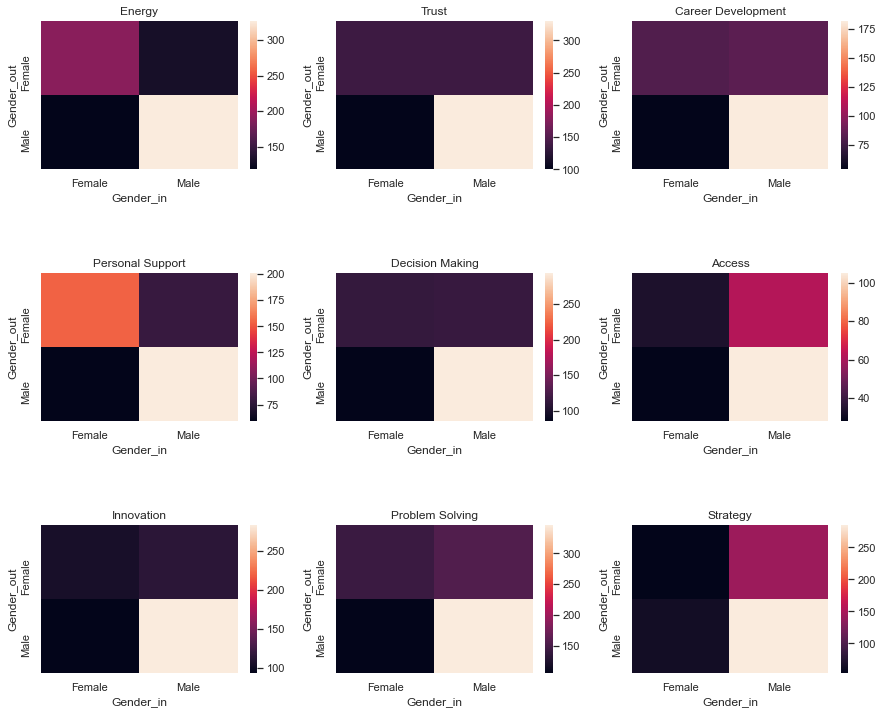

In [97]:
#Gender to gender statistics by label
label = combined['Label'].unique()
plt.figure(figsize=(15,12))

#Energy
sector_e = combined[combined['Label'] == 'Energy']
sector_group_e = sector_e.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_e = sector_group_e.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,1)
sns.heatmap(data=sector_group_e)
plt.title('Energy')

#Trust
sector_t = combined[combined['Label'] == 'Trust']
sector_group_t = sector_t.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_t = sector_group_t.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,2)
sns.heatmap(data=sector_group_t)
plt.title('Trust')

#Career Development
sector_c = combined[combined['Label'] == 'Career Development']
sector_group_c = sector_c.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_c = sector_group_c.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,3)
sns.heatmap(data=sector_group_c)
plt.title('Career Development')


#Personal Support
sector_p = combined[combined['Label'] == 'Personal Support']
sector_group_p = sector_p.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_p = sector_group_p.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,4)
sns.heatmap(data=sector_group_p)
plt.title('Personal Support')

#Decision Making
sector_d = combined[combined['Label'] == 'Decision Making']
sector_group_d = sector_d.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_d = sector_group_d.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,5)
sns.heatmap(data=sector_group_d)
plt.title('Decision Making')

#Access
sector_a = combined[combined['Label'] == 'Access']
sector_group_a = sector_a.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_a = sector_group_a.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,6)
sns.heatmap(data=sector_group_a)
plt.title('Access')

#Innovation
sector_i = combined[combined['Label'] == 'Innovation']
sector_group_i = sector_i.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_i = sector_group_i.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,7)
sns.heatmap(data=sector_group_i)
plt.title('Innovation')

#Problem Solving
sector_r = combined[combined['Label'] == 'Problem Solving']
sector_group_r = sector_r.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_r = sector_group_r.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,8)
sns.heatmap(data=sector_group_r)
plt.title('Problem Solving')


#Strategy
sector_s = combined[combined['Label'] == 'Strategy']
sector_group_s = sector_s.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
sector_group_s = sector_group_s.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
plt.subplot(3,3,9)
sns.heatmap(data=sector_group_s)
plt.title('Strategy')

plt.subplots_adjust(hspace = .7)




''''for i in range(0,len(label)):
    sector = combined[combined['Label'] == label[i]]
    sector_group = sector.groupby(['Gender_out','Gender_in']).Source.count().reset_index()
    sector_group = sector_group.pivot(index='Gender_out',columns = 'Gender_in',values = 'Source')
    sns.heatmap(data=sector_group)'''

## 2. Gender Assortativity 

The assortativity coeffiicent was used to quantify the extent to which gender plays a role in networking. The assortativity coeffiicent gauges the correlation between chracteristics of connected nodes in a network just like the Pearson Correlation Coefficient does: A value always falls bewteen -1 and 1. A postitive assortativity coefficient indicates that nodes with similar characteristics tend to connect to each other. 

In [108]:
#Link data preprocessing
a = [i for i in range(0,612)]
nodes['ID2']= a
nodes2 = nodes.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link2 = link[['Source','Target']]
link2 = link2.rename(columns = {'Source' : 'ID'})
link3 = pd.merge(link2,nodes,how='left')
link4 = pd.merge(link3,nodes2,how='left',on='Target')
link_final = link4[['ID2','ID_Target']]
link_final = link_final.rename(columns = {'ID2':'Source','ID_Target':'Target'})
link_final['link'] = list(zip(link_final['Source'],link_final['Target']))
link_final = link_final['link']

#Node data preprocessing
nodes_network = nodes[['ID','Gender']]
nodes_network2 = nodes[['ID','Gender']]
nodes_network['Gender2'] = nodes_network['Gender'].map({'Male':1, 'Female':2})
nodes_network2['Gender2'] = nodes_network2['Gender'].map({'Female':0,'Male':1})


#Creating a network and compute the assortativity
nodes_network['ID'] = [i for i in range(0,612)]
nodes_network2['ID'] = [i for i in range(0,612)]
g = ig.Graph()
g.add_vertices([i for i in range(0,612)])
g.add_edges(link_final)
g.vs['Gender'] = nodes_network['Gender2']
print('The assortativity of the network is {0}'.format(g.assortativity_nominal('Gender',directed=True)))

The assortativity of the network is 0.26986616946343467


In [109]:
link_linear = link4[['ID2','Gender_x']]

In [110]:
link_linear['Gender'] = link_linear['Gender_x'].map({'Female':0,'Male':1})

<ipython-input-110-75ee430471fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  link_linear['Gender'] = link_linear['Gender_x'].map({'Female':0,'Male':1})


In [111]:
link_linear = link_linear[['ID2','Gender']]

In [112]:
link_linear

,ID2,Gender
0,150,0
1,188,1
2,188,1
3,188,1
4,188,1
...,...,...
5088,494,1
5089,494,1
5090,494,1
5091,276,1


In [113]:
link_linear_group = link_linear.groupby(['ID2']).Gender.count().reset_index()

In [114]:
link_linear_group

,ID2,Gender
0,1,13
1,2,14
2,3,5
3,4,27
4,5,5
...,...,...
413,606,12
414,608,12
415,609,10
416,610,10


In [115]:
link_linear_group = link_linear_group.rename(columns = {'ID2':"ID"})

In [116]:
link_linear_group

,ID,Gender
0,1,13
1,2,14
2,3,5
3,4,27
4,5,5
...,...,...
413,606,12
414,608,12
415,609,10
416,610,10


In [117]:
nodes_network2

,ID,Gender,Gender2
0,0,Female,0
1,1,Female,0
2,2,Female,0
3,3,Female,0
4,4,Female,0
...,...,...,...
607,607,Female,0
608,608,Male,1
609,609,Male,1
610,610,Male,1


In [118]:
link_linear_group_gender = pd.merge(link_linear_group,nodes_network2,how='left',on = 'ID')

In [119]:
link_linear_group_gender

,ID,Gender_x,Gender_y,Gender2
0,1,13,Female,0
1,2,14,Female,0
2,3,5,Female,0
3,4,27,Female,0
4,5,5,Female,0
...,...,...,...,...
413,606,12,Male,1
414,608,12,Male,1
415,609,10,Male,1
416,610,10,Male,1


In [120]:
link_linear_group_gender = link_linear_group_gender[['Gender2','Gender_x']]

In [121]:
link_linear_group_gender

,Gender2,Gender_x
0,0,13
1,0,14
2,0,5
3,0,27
4,0,5
...,...,...
413,1,12
414,1,12
415,1,10
416,1,10


In [122]:
link_linear_group_gender = link_linear_group_gender.rename(columns = {'Gender2':'Gender','Gender_x':'degrees'})

In [123]:
link_linear_group_gender

,Gender,degrees
0,0,13
1,0,14
2,0,5
3,0,27
4,0,5
...,...,...
413,1,12
414,1,12
415,1,10
416,1,10


In [124]:
X = link_linear_group_gender['Gender']
y = link_linear_group_gender['degrees']
X = sm.add_constant(X)
model_gender = sm.OLS(y,X).fit()
predictions =model_gender.predict(X)

In [125]:
model_gender.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                degrees   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3279
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.567
Time:                        23:51:16   Log-Likelihood:                -1481.8
No. Observations:                 418   AIC:                             2968.
Df Residuals:                     416   BIC:                             2976.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4785      0.658     18.961      0.000      11.185      13.772
Gender        -0.4824      0.843     -0.573      0.567      -2.139       1.174
==============================================================================
Omnibus:                      177.442   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              833.468
Skew:                           1.822   Prob(JB):                    1.03e-181
Kurtosis:                       8.881   Cond. No.                         2.96
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [126]:
link_linear_group_gender

,Gender,degrees
0,0,13
1,0,14
2,0,5
3,0,27
4,0,5
...,...,...
413,1,12
414,1,12
415,1,10
416,1,10


In [127]:
link4

,ID,Target,Gender_x,ID2,Gender_y,ID_Target
0,427685,428855,Female,150,Female,8
1,428309,428686,Male,188,Male,524
2,428309,428686,Male,188,Male,524
3,428309,428686,Male,188,Male,524
4,428309,428686,Male,188,Male,524
...,...,...,...,...,...,...
5088,427919,428049,Male,494,Male,600
5089,427919,428049,Male,494,Male,600
5090,427919,428049,Male,494,Male,600
5091,427932,427958,Male,276,Male,511


<b>Conclusion:</b><br>
   The assortativity coefficient of the network is 0.2698, which indicates that there are more edges between same genders compared to a random network. The strength of assortativity is 'weak'. 

## 3. Gender Assortativity by Label
The assortativity coefficients were calculated based on 'label'. 

In [128]:
#Link data preprocessing
link_label = link[['Source','Target','Label']]
link_label = link_label.rename(columns = {'Source' : 'ID'})
link_label2=pd.merge(link_label,nodes,how='left')
link_label3 = pd.merge(link_label2,nodes2,how='left', on='Target')
link_label_final = link_label3[['ID2','ID_Target','Label']]
link_label_final = link_label_final.rename(columns = {'ID2': 'Source','ID_Target':'Target'})
link_label_final['link'] = list(zip(link_label_final['Source'],link_label_final['Target']))
link_label_final2 = link_label_final[['link','Label']]

#create link data with label
labels = link_label_final2['Label'].unique()
link_data_by_label = []
for label in labels:
    new_label = link_label_final2[link_label_final2['Label'] == label]
    link_data_by_label.append(new_label)
    
    
#create a network and compute the assortativity by label    
node_final = [i for i in range(0,612)]
assortativity=[]
for datum in link_data_by_label:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity.append(temp)
    
assortativity_label = {key: value for key, value in zip(labels,assortativity)}
assortativity_label2 = pd.DataFrame(data=list(zip(labels,assortativity)),columns =['Label','Assortativity'])

In [129]:
#print assortativity by label
assortativity_label2

,Label,Assortativity
0,Energy,0.328386
1,Trust,0.271989
2,Career Development,0.265100
3,Personal Support,0.432106
4,Decision Making,0.276716
5,Access,0.130380
6,Innovation,0.233658
7,Problem Solving,0.247229
8,Strategy,0.072249


<b>Conclusion:</b><br>
Assortativity is high for 'Personal Support', 'Energy'and 'Decision Making'. People tend to talk to their own gender for 'Personal Support', 'Energy'and 'Decision Making'.

## 4. The difference in the number of out-degrees between men and women 

In this chapter, we examined the difference in the number of out-degrees between men and women from the sample and tested if the difference is statistically significance by running permutation tests. 

In [130]:
#preprocessing the data 
out_label = link_label_final[['Source','Label']]
out_label = out_label.rename(columns = {'Source':'ID'})
out_label_gender = pd.merge(out_label,nodes_network,how = 'left',on = 'ID')
out_label_male = out_label_gender[out_label_gender['Gender'] == 'Male']
out_label_female = out_label_gender[out_label_gender['Gender'] == 'Female']
number_degree_male = out_label_male.groupby(['ID']).Gender.count().reset_index()
number_degree_male = number_degree_male.rename(columns = {'Gender': 'Number of out-degree'})
number_degree_female = out_label_female.groupby(['ID']).Gender.count().reset_index()
number_degree_female = number_degree_female.rename(columns = {'Gender':'Number of out-degree'})
number_degree_male2 = number_degree_male['Number of out-degree']
number_degree_female2 = number_degree_female['Number of out-degree']

In [131]:
#split the data into men and women in terms of # of out-degress 
nodes_network_male = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male21 = pd.merge(nodes_network_male,number_degree_male,how='left',on = 'ID')
nodes_network_male2=nodes_network_male21.fillna(0)
nodes_network_female = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female21 = pd.merge(nodes_network_female,number_degree_female,how='left',on = 'ID')
nodes_network_female2=nodes_network_female21.fillna(0)
nodes_network_male2 = nodes_network_male2['Number of out-degree']
nodes_network_female2 = nodes_network_female2['Number of out-degree']
average_male_out = np.mean(nodes_network_male2)
average_female_out = np.mean(nodes_network_female2)
outdegree_diff = pd.DataFrame(np.array([[average_male_out,average_female_out]]),columns = ['Male','Female'],index=['# of out-degrees'])


In [132]:
outdegree_diff

,Male,Female
# of out-degrees,7.783715,9.287671


Text(0.5, 1.0, 'Number of Out-degree by Gender')

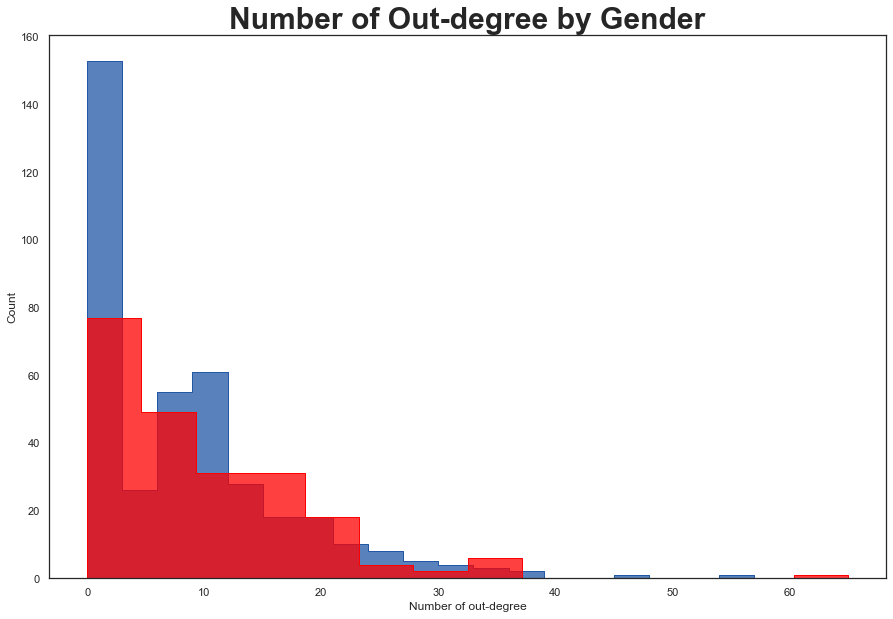

In [136]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male2,element='step',color='#2157A4')
sns.histplot(nodes_network_female2,element = 'step',color='red')

ax.set_title('Number of Out-degree by Gender',fontweight = 'bold',fontsize=30)

## Permutation test on the average out-degree between male and female groups 

In [137]:
tstat,pval_ttest_out2 = ttest_ind(nodes_network_male2,nodes_network_female2)
p_val_permu_out2 = permutation_test(nodes_network_male2,nodes_network_female2,method='approximate',num_rounds = 10000,seed=0)

In [138]:
pval_ttest_out2

0.04646645411248457

In [139]:
p_val_permu_out2

0.0471952804719528

<b>Conclusion:</b><br>
A p-value of .047 indicates that we would see the observed sample result only 4.7% of the time under the assumption that there's no difference in the average out-degrees between men and women. Thus we reject the null hypothesis indicating that there's a statistically significant different in the number of out-degrees betweeen men and women based on 0.05 threshold. 

## 4. The difference in the number of in-degrees between men and women 

The difference in the number of in-degrees between men and women was calculated. 

In [140]:
in_label = link_label_final[['Target','Label']]
in_label =in_label.rename(columns ={'Target':'ID'})
in_label_gender = pd.merge(in_label,nodes_network,how='left',on='ID')
in_label_male = in_label_gender[in_label_gender['Gender'] =='Male']
in_label_female = in_label_gender[in_label_gender['Gender'] =='Female']
number_in_male = in_label_male.groupby(['ID']).Gender.count().reset_index()
number_in_female = in_label_female.groupby(['ID']).Gender.count().reset_index()
number_in_male = number_in_male.rename(columns = {'Gender': 'Number of in-degree'})
number_in_female = number_in_female.rename(columns = {'Gender': 'Number of in-degree'})
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male2_in = pd.merge(nodes_network_male_in,number_in_male,how='left',on = 'ID')
nodes_network_male3_in = nodes_network_male2_in.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female2_in = pd.merge(nodes_network_female_in,number_in_female,how='left',on = 'ID')
nodes_network_female3_in=nodes_network_female2_in.fillna(0)
nodes_network_male3_in = nodes_network_male3_in['Number of in-degree']
nodes_network_female3_in = nodes_network_female3_in['Number of in-degree']
average_male_in = np.mean(nodes_network_male3_in)
average_female_in = np.mean(nodes_network_female3_in)
indegree_diff = pd.DataFrame(np.array([[average_male_in,average_female_in]]),columns = ['Male','Female'],index=['# of in-degrees'])


In [141]:
indegree_diff

,Male,Female
# of in-degrees,8.592875,7.835616


Text(0.5, 1.0, 'Number of In-degree by Gender')

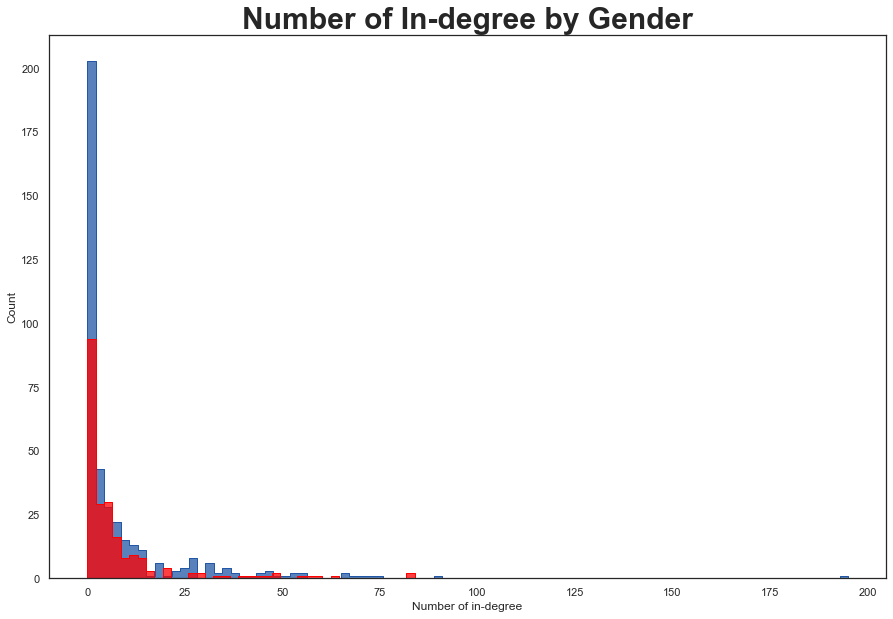

In [144]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in,element='step',color='#2157A4')
sns.histplot(nodes_network_female3_in,element = 'step',color='red')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

## Permutation test on the average In-degree between male and female group

In [145]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in,nodes_network_female3_in)
p_val_permu_in2 = permutation_test(nodes_network_male3_in,nodes_network_female3_in,method='approximate',num_rounds = 10000,seed=0)

In [146]:
pval_ttest_in2

0.5712703414065738

In [147]:
p_val_permu_in2

0.5823417658234177

<b>Conclusion:</b><br>
The p-value for the number of in-degrees is 0.58, which is greater than 0.05. We failed to reject the null hypothesis; in our smaple women have a higher connections, but this result is not statistically significant. 

## Number of in-degree by Gender (without outliers)

We visually detected a couple of outliers from the histograms aboves. Since these outliers tend to be more seniors, they migth have been responsible for having more connections. Assuming that this interpretation is true, we thought that eliminating outliers might help reduce noise.  

In [148]:
number_in_male_outlier = number_in_male[number_in_male['ID'] !=610]
number_in_female_outlier = number_in_female[number_in_female['ID'] != 607]
nodes_network_male_in = nodes_network[nodes_network['Gender']=='Male']
nodes_network_male_in_outlier = nodes_network_male_in[nodes_network_male_in['ID']!=610]
nodes_network_male2_in_outlier = pd.merge(nodes_network_male_in_outlier,number_in_male_outlier,how='left',on = 'ID')
nodes_network_male3_in_outlier = nodes_network_male2_in_outlier.fillna(0)
nodes_network_female_in = nodes_network[nodes_network['Gender']=='Female']
nodes_network_female_in_outlier = nodes_network_female_in[nodes_network_female_in['ID'] != 607]
nodes_network_female2_in_outlier = pd.merge(nodes_network_female_in_outlier,number_in_female_outlier,how='left',on = 'ID')
nodes_network_female3_in_outlier=nodes_network_female2_in_outlier.fillna(0)
nodes_network_male3_in_o = nodes_network_male3_in_outlier['Number of in-degree']
nodes_network_female3_in_o = nodes_network_female3_in_outlier['Number of in-degree']


Text(0.5, 1.0, 'Number of In-degree by Gender')

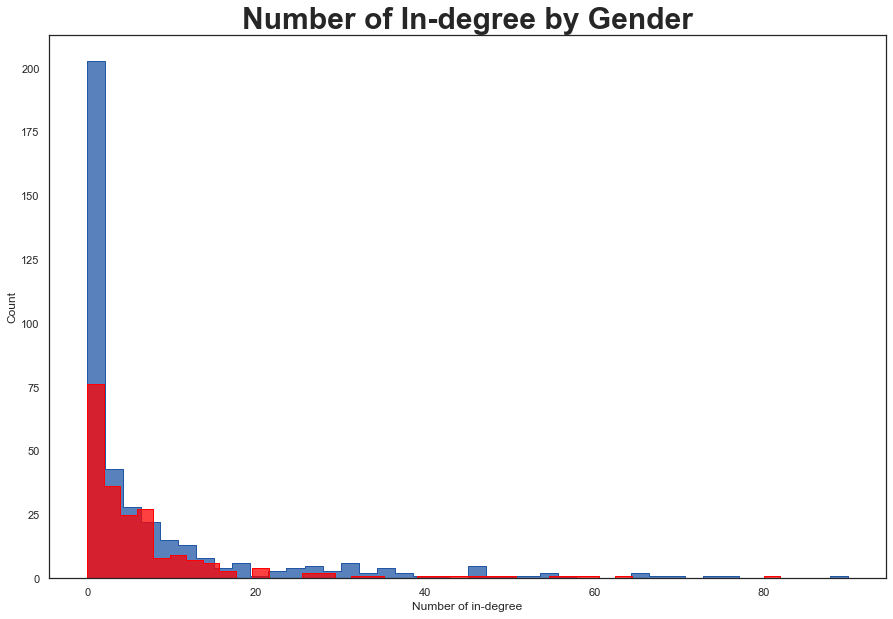

In [150]:
f,ax = plt.subplots(figsize = (15,10))
sns.histplot(nodes_network_male3_in_o,element='step',color='#2157A4')
sns.histplot(nodes_network_female3_in_o,element = 'step',color='red')

ax.set_title('Number of In-degree by Gender',fontweight = 'bold',fontsize=30)

In [342]:
tstat,pval_ttest_in2 = ttest_ind(nodes_network_male3_in_o,nodes_network_female3_in_o)
p_val_permu_in2 = permutation_test(nodes_network_male3_in_o,nodes_network_female3_in_o,method='approximate',num_rounds = 10000,seed=0)

In [343]:
pval_ttest_in2

0.5833244325643967

In [344]:
p_val_permu_in2

0.5807419258074192

<b>Conclusion:</b><br>
Even without top 3 outliers from both men and women groups, the p-value of .58 tells us that there's no statistical significant differences in the number of in-dgrees between them. 

In [345]:
print('average number of in-degrees for male without an outlier: {0}'.format(nodes_network_male3_in_o.mean()))

average number of in-degrees for male without an outlier: 8.11734693877551


In [346]:
print('average number of in-degrees for female without an outlier: {0}'.format(nodes_network_female3_in_o.mean()))

average number of in-degrees for female without an outlier: 7.486238532110092


## Number of Out-degrees by 'Gender' and 'LabeL'
raw data: out_label_gender  -> out_label_male , out_label_female

In [347]:
#number of out-degrees by gender and label
number_degree_male_label = out_label_male.groupby(['ID','Label']).Gender.count().reset_index()
number_degree_female_label = out_label_female.groupby(['ID','Label']).Gender.count().reset_index()

#group the above data by label 
out_data_label_male = []
for label in labels:
    new_label = number_degree_male_label[number_degree_male_label['Label'] == label]
    out_data_label_male.append(new_label)
    
out_data_label_female = []
for label in labels:
    new_label = number_degree_female_label[number_degree_female_label['Label'] == label]
    out_data_label_female.append(new_label)

    
#permutation test to see if there's significant difference in the average number of out-degrees by gender and label
p_val_permu_out_label = []
for i in range(9):
    p_val_permu_out_label.append(permutation_test(out_data_label_male[i].Gender,out_data_label_female[i].Gender,method='approximate',num_rounds = 10000,seed=0))

#create a list: (label,p-value)
p_val_by_label = [(label,pval) for label, pval in list(zip(labels,p_val_permu_out_label))]

print('p-values for difference in averge out-degree by label')
p_val_by_label

p-values for difference in averge out-degree by label


[('Energy', 0.11018898110188981),
 ('Trust', 0.616938306169383),
 ('Career Development', 0.31786821317868214),
 ('Personal Support', 0.0034996500349965005),
 ('Decision Making', 0.9222077792220778),
 ('Access', 0.51994800519948),
 ('Innovation', 0.7030296970302969),
 ('Problem Solving', 0.7081291870812919),
 ('Strategy', 0.37066293370662934)]


For only personal support, there's a statistical significance in # of outdegree difference between men and women

In [348]:
#average number of out-degrees by gender and label
mean_by_label_male = []
mean_by_label_female = []
for i in range(9):
    mean_by_label_male.append(out_data_label_male[i].Gender.mean())
    mean_by_label_female.append(out_data_label_female[i].Gender.mean())
mean_by_label = list(zip(mean_by_label_male,mean_by_label_female))

#create a list: [label,mean(men,women)]
mean_by_label = [(label,mean) for label,mean in zip(labels,mean_by_label)]

#print the list
print('average # of out-degrees for men and women by label ')
mean_by_label

average # of out-degrees for men and women by label 


[('Energy', (2.109004739336493, 2.450381679389313)),
 ('Trust', (1.9907407407407407, 2.0757575757575757)),
 ('Career Development', (1.4047619047619047, 1.5137614678899083)),
 ('Personal Support', (1.6049382716049383, 2.0172413793103448)),
 ('Decision Making', (1.730593607305936, 1.7164179104477613)),
 ('Access', (1.75, 1.9591836734693877)),
 ('Innovation', (2.1123595505617976, 2.018348623853211)),
 ('Problem Solving', (2.0688073394495414, 2.143884892086331)),
 ('Strategy', (1.6778846153846154, 1.5555555555555556))]

As can be seen, other areas have simliar average connections betweeen men and women except 'Personal Support'

## Gender Assortativity by Division

In [349]:
nodes_all2 = pd.read_csv(r'/Users/PJMoon/Data_Science_Projects/SNA/Assortativity/Nodes with attributes_V2.csv')

In [350]:
nodes_all2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  612 non-null    float64
 1   Full Name           612 non-null    object 
 2   Invited             612 non-null    object 
 3   Responded           612 non-null    object 
 4   Organization        612 non-null    object 
 5   Division            612 non-null    object 
 6   Function/Deparment  612 non-null    object 
 7   Title               612 non-null    object 
 8   Level               612 non-null    float64
 9   Location            611 non-null    object 
 10  Tenure              536 non-null    float64
 11  Manager             612 non-null    object 
 12  Team                377 non-null    object 
 13  Gender              612 non-null    object 
 14  Unnamed: 14         0 non-null      float64
 15  Unnamed: 15         0 non-null      float64
 16  Unnamed:

In [351]:
nodes_all2.columns

Index(['ID', 'Full Name', 'Invited', 'Responded', 'Organization', 'Division',
       'Function/Deparment', 'Title', 'Level', 'Location', 'Tenure', 'Manager',
       'Team', 'Gender', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'],
      dtype='object')

In [352]:
nodes_all2.Location.value_counts()

US - Work From Home                438
US - NY - Rochester - 313           69
Canada - Work From Home             41
US - NJ - Raritan                   33
US - NY - Rochester - CNP - 100     19
Canada - Markham                    11
Name: Location, dtype: int64

In [353]:
nodes_all2

,ID,Full Name,Invited,Responded,Organization,Division,Function/Deparment,Title,Level,Location,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,428634.0,Agnes Friesen,YES,NO,Ortho,Andrew Corkum,Selling - Commercial,Ortho Care Laboratory Specialist,4.0,Canada - Work From Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,428764.0,Barbara Schonewille,YES,YES,Ortho,Andrew Corkum,Selling - Commercial,Account Manager - Alberta Canada Territory,3.0,Canada - Work From Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,428881.0,Carli-Ann Garnett,YES,YES,Ortho,Andrew Corkum,Marketing - Commercial,"Manager, IH Marketing and Commercial Excellence",3.0,Canada - Work From Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,428738.0,Cheryl Dosen,YES,YES,Ortho,Andrew Corkum,Selling - Commercial,Account Manager - West,4.0,Canada - Work From Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,428803.0,Helene Goulet,YES,YES,Ortho,Andrew Corkum,Selling - Commercial,National Automation Specialist,3.0,Canada - Work From Home,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
767,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
768,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
769,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [354]:
nodes_all2[nodes_all2['Full Name'] == 'Michael Iskra']

,ID,Full Name,Invited,Responded,Organization,Division,Function/Deparment,Title,Level,Location,...,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27
610,442219.0,Michael Iskra,YES,YES,Ortho,Michael Iskra,0,0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [355]:
nodes_all2.columns

Index(['ID', 'Full Name', 'Invited', 'Responded', 'Organization', 'Division',
       'Function/Deparment', 'Title', 'Level', 'Location', 'Tenure', 'Manager',
       'Team', 'Gender', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27'],
      dtype='object')

In [356]:
#select columns of interst from node data 
nodes_div = nodes_all2[['ID','Gender','Division']]

#drop rows with N/A
nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_div['ID2']= a
nodes_div_temp = nodes_div

#rearrange the order of columns
nodes_div_temp = nodes_div_temp[['ID2','Gender','Division']]


#encode the gender variable
nodes_div_temp['Gender2'] = nodes_div_temp['Gender'].map({'Male':1,'Female':2})

#create a division name list
divisions = nodes_div.Division.unique()
nodes_division = []
for division in divisions:
    nodes_division.append(nodes_div_temp[nodes_div_temp['Division'] == division])
    

#create a division size list
division_size = []
for i in range(len(divisions)):
    division_size.append(len(nodes_division[i]))


#combine division names and division size into a list
division_size = [(divisions,size) for divisions,size in list(zip(divisions,division_size))]

<ipython-input-356-aceb3dc02e28>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div.dropna(subset=['ID','Gender','Division'],inplace = True)
<ipython-input-356-aceb3dc02e28>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_div['ID2']= a


In [357]:
#Link data preprocessing
nodes_div2 = nodes_div.rename(columns = {'ID':'Target','ID2':'ID_Target'})
link_div = link[['Source','Target']]
link_div = link_div.rename(columns = {'Source' : 'ID'})
link_div2 = pd.merge(link_div,nodes_div,how='left')
link_div3 = pd.merge(link_div2,nodes_div2,how='left',on='Target')
link_div4 = link_div3[['ID2','ID_Target','Division_x']]
link_final_div = link_div4.rename(columns = {'ID2':'Source','ID_Target':'Target','Division_x':'Division_source'})
link_final_div['link'] = list(zip(link_final_div['Source'],link_final_div['Target']))
link_final_div = link_final_div[['link','Division_source']]

link_by_div = []
for division in divisions:
    link_by_div.append(link_final_div[link_final_div['Division_source'] == division])

In [358]:
total_div = []
male_female_div = []
male_male_div = []
female_male_div = []
female_female_div = []
for i in range(len(divisions)):
    total_div.append(len(link_div3[link_div3['Division_x']==divisions[i]]))
    male_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Female')]))
    male_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Male') &(link_div3['Gender_y'] =='Male')]))
    female_female_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Female')]))
    female_male_div.append(len(link_div3[(link_div3['Division_x'] == divisions[i]) & (link_div3['Gender_x'] == 'Female') &(link_div3['Gender_y'] =='Male')]))

link_distribution_division = pd.DataFrame(list(zip(total_div,male_male_div,male_female_div,female_female_div,female_male_div)),columns = ['total links','male to male','male to female','female to female','female to male'],
                                         index = [division for division in divisions ])
    

In [359]:
list(zip(total_div,male_male_div,male_female_div,female_female_div,female_male_div))

[(327, 109, 49, 117, 52),
 (826, 242, 61, 255, 268),
 (607, 145, 154, 176, 132),
 (205, 88, 21, 26, 70),
 (509, 232, 82, 78, 117),
 (522, 151, 108, 165, 98),
 (1351, 1129, 75, 25, 122),
 (637, 180, 135, 167, 155),
 (109, 77, 21, 1, 10)]

In [360]:
#Creating a network and compute the assortativity
assort_by_div = []
for i in range(len(divisions)):
    g1 = ig.Graph()
    g1.add_vertices([i for i in range(0,612)])
    g1.add_edges(link_by_div[i]['link'])
    g1.vs['Gender'] = nodes_network['Gender2']
    assort_by_div.append(g1.assortativity_nominal('Gender',directed=True))

assort_div = [(division,assortativity) for division,assortativity in zip(divisions,assort_by_div)]

In [361]:
assort_by_div

[0.3818930426238713,
 0.20319246100685065,
 0.055196360153256706,
 0.022812393598910505,
 0.13928579015571557,
 0.21015983076742273,
 0.12218475061223537,
 0.08910256410256412,
 -0.1069615069615072]

In [362]:
assort_div

[('Andrew Corkum', 0.3818930426238713),
 ('Bob Bolger', 0.20319246100685065),
 ('Dennis Bassett', 0.055196360153256706),
 ('Glen Tinevez', 0.022812393598910505),
 ('John Meckles', 0.13928579015571557),
 ('Kristy Hanson', 0.21015983076742273),
 ('Patrick Rigby', 0.12218475061223537),
 ('Timothy Adams', 0.08910256410256412),
 ('Michael Iskra', -0.1069615069615072)]

In [363]:
link_distribution_division['Assortativity'] = assort_by_div

## Difference in Average # of out-degrees by Level

In [365]:
nodes_level_temp

,Source,Gender,Level,Gender2
0,0,Female,4.0,2
1,1,Female,3.0,2
2,2,Female,3.0,2
3,3,Female,4.0,2
4,4,Female,3.0,2
...,...,...,...,...
607,607,Female,2.0,2
608,608,Male,2.0,1
609,609,Male,2.0,1
610,610,Male,1.0,1


In [366]:
#select columns of interst from node data 
nodes_level = nodes_all2[['ID','Gender','Level']]

#drop rows with N/A
nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)

#add a ID2 column with a series:(0,612)
nodes_level['ID2']= a
nodes_level_temp = nodes_level


#rearrange the order of columns
nodes_level_temp = nodes_level_temp[['ID2','Gender','Level']]


#encode the gender variable
nodes_level_temp['Gender2'] = nodes_level_temp['Gender'].map({'Male':1,'Female':2})
nodes_level_temp_male = nodes_level_temp[nodes_level_temp['Gender'] =='Male'].rename(columns = {'ID2':'ID'})
nodes_level_temp_female = nodes_level_temp[nodes_level_temp['Gender'] =='Female'].rename(columns = {'ID2': 'ID'})


nodes_level_temp = nodes_level_temp.rename(columns={'ID2':'Source'})
nodes_level_temp2 = nodes_level_temp.rename(columns={'Source': 'Target'})

nodes_level2 = nodes_level.rename(columns = {'ID':'Target','ID2':'ID_Target'})



<ipython-input-366-b6f260a1b386>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level.dropna(subset=['ID','Gender','Level'],inplace = True)
<ipython-input-366-b6f260a1b386>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_level['ID2']= a


In [367]:
nodes_level_temp

,Source,Gender,Level,Gender2
0,0,Female,4.0,2
1,1,Female,3.0,2
2,2,Female,3.0,2
3,3,Female,4.0,2
4,4,Female,3.0,2
...,...,...,...,...
607,607,Female,2.0,2
608,608,Male,2.0,1
609,609,Male,2.0,1
610,610,Male,1.0,1


In [368]:
link_level_linear_male = link_level_male[['Number of out-degree','Level']]

In [369]:
link_level_linear_gender = link_level_male[['Number of out-degree','Level','Gender2']]

In [370]:
link_level_linear_female = link_level_female[['Number of out-degree','Level']]

In [371]:
link_level_linear_gender2 = link_level_female[['Number of out-degree','Level','Gender2']]

In [372]:
frames = [link_level_linear_male,link_level_linear_female]

In [373]:
frames2 = [link_level_linear_gender,link_level_linear_gender2]

In [374]:
link_level_linear = pd.concat(frames)

In [375]:
link_level_linear_gender = pd.concat(frames2)

In [376]:
link_level_linear_gender

,Number of out-degree,Level,Gender2
0,0.0,4.0,1
1,7.0,4.0,1
2,5.0,4.0,1
3,8.0,4.0,1
4,0.0,5.0,1
...,...,...,...
214,4.0,4.0,2
215,0.0,4.0,2
216,18.0,4.0,2
217,11.0,2.0,2


In [377]:
X2 = link_level_linear_gender[['Level','Gender2']]
y2 = link_level_linear_gender['Number of out-degree']
X2 = sm.add_constant(X2)
model_level_gender = sm.OLS(y2,X2).fit()
predictions_level =model_level_gender.predict(X2)

In [378]:
link_level_linear_group = link_level_linear.groupby(['Level'])['Number of out-degree'].sum().reset_index()

In [379]:
link_level_linear_group

,Level,Number of out-degree
0,1.0,10.0
1,2.0,99.0
2,3.0,751.0
3,4.0,2374.0
4,5.0,1859.0


In [380]:
X1 = link_level_linear['Level'] 
y1 = link_level_linear['Number of out-degree']
X1 = sm.add_constant(X1)
model_level = sm.OLS(y1,X1).fit()
predictions_level =model_level.predict(X)

In [381]:
model_level.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Number of out-degree   R-squared:                       0.039
Model:                              OLS   Adj. R-squared:                  0.038
Method:                   Least Squares   F-statistic:                     25.07
Date:                  Mon, 10 May 2021   Prob (F-statistic):           7.26e-07
Time:                          12:15:29   Log-Likelihood:                -2197.6
No. Observations:                   612   AIC:                             4399.
Df Residuals:                       610   BIC:                             4408.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.7904      2.121      8.860      0.000      14.625      22.955
Level         -2.4176      0.483     -5.007      0.000      -3.366      -1.469
==============================================================================
Omnibus:                      226.140   Durbin-Watson:                   1.939
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              920.084
Skew:                           1.670   Prob(JB):                    1.61e-200
Kurtosis:                       7.993   Cond. No.                         27.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [382]:
#link data preprocessing - male
link_level_male = pd.merge(nodes_network_male21,nodes_level_temp_male,how='left')
link_level_male = link_level_male.fillna(0)

#link data preprocessing - female
link_level_female = pd.merge(nodes_network_female21,nodes_level_temp_female,how='left')
link_level_female = link_level_female.fillna(0)


#break gender data in different levels
level_male_data = []
for i in range(1,6):
    level_male_data.append(link_level_male[link_level_male['Level'] == i])
    
level_female_data = []
for i in range(1,6):
    level_female_data.append(link_level_female[link_level_female['Level'] == i])
    
pval_by_level = []
pval_by_level_t = []
for i in range(0,5):
     pval_by_level.append(permutation_test(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree'],method='approximate',num_rounds = 10000,seed=0))
     t_stat, pvalue = ttest_ind(level_male_data[i]['Number of out-degree'],level_female_data[i]['Number of out-degree'])
     pval_by_level_t.append(pvalue)
    

level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2 = [(level,pval) for level,pval in zip(level,pval_by_level)]
pval_by_level_t2 = [(level,pval) for level,pval in zip(level,pval_by_level_t)]        
        
pval_by_level_table = pd.DataFrame(list(zip(level,pval_by_level_t)),columns = ['Level','P-value'])
    

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [383]:
pval_by_level_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.131013
2,Level:3,0.604524
3,Level:4,0.318692
4,Level:5,0.002616


In [384]:
pval_by_level_t2

[('Level:1', nan),
 ('Level:2', 0.13101252402855024),
 ('Level:3', 0.6045241112974844),
 ('Level:4', 0.31869237839015446),
 ('Level:5', 0.002615686787267152)]

In [385]:
#find the number of data by gender and level
male_n = []
female_n = []
for i in range(0,5):
    male_n.append(len(level_male_data[i]))
    female_n.append(len(level_female_data[i]))
n_by_level = list(zip(male_n,female_n))  
n_by_level = dict(zip(level2,n_by_level))

In [386]:
n_by_level

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [387]:
#find the average number of out-degrees by gender and level
male_mean_degree = []
female_mean_degree = []
for i in range(0,5):
    male_mean_degree.append(level_male_data[i]['Number of out-degree'].mean())
    female_mean_degree.append(level_female_data[i]['Number of out-degree'].mean())
    
mean_degree_level = list(zip(male_mean_degree,female_mean_degree))  
mean_degree_level = dict(zip(level3,mean_degree_level))

mean_degree_level_table = pd.DataFrame(list(zip(level3,male_mean_degree,female_mean_degree)),columns=['Level','Male','Female'])

In [388]:
mean_degree_level_table

,Level,Male,Female
0,Level:1,10.000000,NaN
1,Level:2,12.571429,5.500000
2,Level:3,11.119048,12.347826
3,Level:4,10.119048,8.934959
4,Level:5,5.617512,9.014085


## Difference in Average # of In-degrees by Level

In [389]:
#link data preprocessing - male
link_level_male_in = pd.merge(nodes_network_male2_in,nodes_level_temp_male,how='left')
link_level_male_in = link_level_male_in.fillna(0)

#link data preprocessing - female
link_level_female_in = pd.merge(nodes_network_female2_in,nodes_level_temp_female,how='left')
link_level_female_in = link_level_female_in.fillna(0)


#split gender data in five different levels
level_male_data_in = []
for i in range(1,6):
    level_male_data_in.append(link_level_male_in[link_level_male_in['Level'] == i])
    
level_female_data_in = []
for i in range(1,6):
    level_female_data_in.append(link_level_female_in[link_level_female_in['Level'] == i])
    
pval_by_level_in = []
pval_by_level_t_in = []
for i in range(0,5):
    pval_by_level_in.append(permutation_test(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree'],method='approximate',num_rounds = 10000,seed=0))
    tstat2,pval2 = ttest_ind(level_male_data_in[i]['Number of in-degree'],level_female_data_in[i]['Number of in-degree'])
    pval_by_level_t_in.append(pval2)


level = ['Level:{0}'.format(v) for v in list(range(1,6)) ]  
level2 = ['Level {0}:[male,female]'.format(v) for v in list(range(1,6))]
level3 = ['Level:{0}'.format(v) for v in list(range(1,6))]

pval_by_level2_in = [(level,pval) for level,pval in zip(level,pval_by_level_in)]
pval_by_level_t2_in = [(level,pval) for level,pval in zip(level,pval_by_level_t_in)]        

pval_by_level_t2_table = pd.DataFrame(list(zip(level,pval_by_level_t_in)),columns = ['Level','P-value'])
    

/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/PJMoon/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [390]:
pval_by_level_t2_table

,Level,P-value
0,Level:1,NaN
1,Level:2,0.863937
2,Level:3,0.302548
3,Level:4,0.638346
4,Level:5,0.761809


In [391]:
pval_by_level_t2_in

[('Level:1', nan),
 ('Level:2', 0.8639365731351777),
 ('Level:3', 0.3025483504916912),
 ('Level:4', 0.638346003573503),
 ('Level:5', 0.761809144213205)]

In [392]:
#find the number of datapoints by gender and level
male_n_in = []
female_n_in = []
for i in range(0,5):
    male_n_in.append(len(level_male_data_in[i]))
    female_n_in.append(len(level_female_data_in[i]))
n_by_level_in = list(zip(male_n_in,female_n_in))  
n_by_level_in = dict(zip(level2,n_by_level_in))

In [393]:
n_by_level_in

{'Level 1:[male,female]': (1, 0),
 'Level 2:[male,female]': (7, 2),
 'Level 3:[male,female]': (42, 23),
 'Level 4:[male,female]': (126, 123),
 'Level 5:[male,female]': (217, 71)}

In [394]:
#find the average number of out-degrees by gender and level
male_mean_in_degree = []
female_mean_in_degree = []
for i in range(0,5):
    male_mean_in_degree.append(level_male_data_in[i]['Number of in-degree'].mean())
    female_mean_in_degree.append(level_female_data_in[i]['Number of in-degree'].mean())
    
mean_degree_level_in = list(zip(male_mean_in_degree,female_mean_in_degree))  
mean_degree_level_in = dict(zip(level3,mean_degree_level_in))

mean_degree_level_in_table = pd.DataFrame(list(zip(level3,male_mean_in_degree,female_mean_in_degree)),columns=['Level','Male','Female'])

In [395]:
mean_degree_level_in_table

,Level,Male,Female
0,Level:1,195.000000,NaN
1,Level:2,49.714286,44.500000
2,Level:3,29.571429,23.695652
3,Level:4,7.619048,7.008130
4,Level:5,2.912442,3.098592


## Gender Assortativity by Level

I would like to compute gender assortativity by level. My hypothesis is that level 5 has the highest gender assortativity because they do not have a pressure to be connected. 

In [396]:
nodes_level_temp_target

NameError: name 'nodes_level_temp_target' is not defined

In [398]:
link_level_assort_full = pd.merge(link_level_assort,nodes_level_temp_target,how='left',on='Target')

NameError: name 'link_level_assort' is not defined

In [399]:
level5 = link_level_assort_full[link_level_assort_full['Level_x'] == 5]

NameError: name 'link_level_assort_full' is not defined

In [ ]:
level5

In [ ]:
level5.Level_y.value_counts()

In [ ]:
link_level = link_label_final[['Source','Target','link']]
link_level_assort = pd.merge(link_level,nodes_level_temp,how='left',on='Source')
nodes_level_temp_target = nodes_level_temp.rename(columns ={'Source':'Target'})
link_level_assort2=link_level_assort[['link','Level']]

link_level_assort_full = pd.merge(link_level_assort,nodes_level_temp_target,how='left',on='Target')
#create link data with level
levels = nodes_level_temp['Level'].unique()
levels.sort()
link_data_by_level = []
for level in levels:
    new_level = link_level_assort2[link_level_assort2['Level'] == level]
    link_data_by_level.append(new_level)
    
    
#create a network and compute the assortativity by label    
node_final_assort = [i for i in range(0,612)]
assortativity_level=[]
for datum in link_data_by_level:
    g = ig.Graph()
    g.add_vertices(node_final)
    g.add_edges(datum['link'])
    g.vs['Gender'] = nodes_network['Gender2']
    temp = g.assortativity_nominal('Gender',directed = True)
    assortativity_level.append(temp)
    
assortativity_level2 = {key: value for key, value in zip(levels,assortativity_level)}
assortativity_level3 = pd.DataFrame(list(zip(levels,assortativity_level)), columns = ['Level','Assortativity'])

In [397]:
assortativity_level3

NameError: name 'assortativity_level3' is not defined

In [684]:
values = [[42785,428855,'Energy','Female'],
    [43432,428686,'Trust','Male'],
    [43432,428686,'Career','Male'],
    [43432,428686,'Personal','Male'],
    [43432,428634,'Trust','Female']
    ]
df = pd.DataFrame(values, columns =['ID','Target','Label','Gender'])
new_df = df.groupby(['Gender','Label']).ID.count().reset_index()
new_df['Gender2'] = new_df.Gender.map({'Female':0,'Male':1})
new_df['NormID'] = new_df.apply(lambda row: row['ID']/219 if row['Gender2'] == 0 else row['ID']/393, axis = 1)

In [685]:
new_df

,Gender,Label,ID,Gender2,NormID
0,Female,Energy,1,0,0.004566
1,Female,Trust,1,0,0.004566
2,Male,Career,1,1,0.002545
3,Male,Personal,1,1,0.002545
4,Male,Trust,1,1,0.002545
